# 银行营销策略分析

# 目录
## 1. [数据说明与预处理](#1.数据说明与预处理)
## 2. [探索性分析](#2.探索性分析)
&emsp;&emsp;2.1. [数值型特征的分布情况](#2.1.数值型特征的分布情况)       
&emsp;&emsp;2.2. [特征间的相关性](#2.3.特征间的相关性)    
## 3. [数据预处理与特征工程](#3.特征工程)
&emsp;&emsp;3.1. [缺失值处理](#3.1.缺失值处理)    
&emsp;&emsp;3.2. [类型转换](#3.2.类型转换)    
## 4. [模型训练](#4.模型训练)  
&emsp;&emsp;4.1. [数据集划分](#4.1.数据集划分)     
&emsp;&emsp;4.2. [模型构建](#4.2.模型构建)    
&emsp;&emsp;4.3. [模型评价](#4.3.模型评价)    
## 5. [总结](#5.总结)  

# 1.数据说明与预处理
本文选取的数据集来自于葡萄牙银行机构的营销活动，是以电话访谈的形式，根据访谈结果整合而成的。而电话访谈的最终目的，则是判断该用户是否会认购银行的产品——定期存款（term deposit）。因此，与该数据集对应的任务是分类任务，而分类目标是预测客户是(yes)否(no)认购定期存款，对应了数据集中的特征 `y` 。

数据集一共包含了41188个样例和17个特征，它们的含义如下表所示。
+ **I.客户个人信息** 

|列名|含义说明|
|:-:|:-:|
|age|年龄|
|job|工作|
|marital|婚姻状况|
|education|受教育程度|
|default|是否有违约记录|
|housing|是否有住房贷款|
|loan|是否有个人贷款|
|balance|个人存款余额|

+ **II.上一次电话营销的记录** 

|列名|含义说明|
|:-:|:-:|
|contact|联系途径|
|month|月份|
|day|日期|
|duration|持续时间|

+ **III.其他记录** 

|列名|含义说明|
|:-:|:-:|
|campaign|在本次营销周期内与该客户的总通话次数|
|pdays|距离上一次通话的时间|
|previous|在过去的营销活动中与该客户的总通话次数|
|poutcome|上一次营销活动是否成功|

+ **IV.目标特征** 

|列名|含义说明|
|:-:|:-:|
|y|是否认购定期存款|


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix
import time
from scipy import sparse
# init_notebook_mode(connected=True)

然后导入数据集。我们将包含所有数据的数据集命名为 bank ，通过前五行数据简要查看数据集的构成。

In [62]:
bank = pd.read_csv('./data/bank-full.csv',sep=';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


接下来我们通过 describe() 和 info() 函数查看各列数据的分布情况。 这里我们首先用 describe() 函数分别观察数值型（numeric）特征的分布和类别型（categorical）特征的分布。 下边是数值型（numeric）特征的分布。

In [63]:
bank.describe() #数值型（numeric）特征数据分布

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


接着我们观察类别型（categorical）特征的分布

In [64]:
bank.describe(include=['O']) #类别型（categorical）特征数据分布

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


下边用info()观察缺失值的情况

In [65]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


通过观察 info() 函数给我们的结果，我们可以看出数据集中不存在缺失值。但是在此数据表中，部分数据以字符串 'unknown' 形式存在于类别型特征里。使用如下代码查看类别型特征中 'unknown' 的个数。

In [66]:
for col in bank.select_dtypes(include=['object']).columns:  #筛选类型为object型数据，统计'unknown'个数
    print(col+':',bank[bank[col]=='unknown'][col].count())

job: 288
marital: 0
education: 1857
default: 0
housing: 0
loan: 0
contact: 13020
month: 0
poutcome: 36959
y: 0


对于 'unknown' 值的处理，我们会在3.1进行分析。

我们接下来查看样本类别分布情况。

In [67]:
bank['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

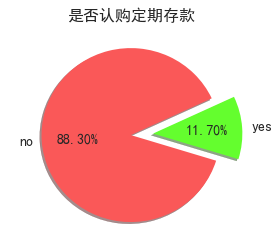

In [68]:
f, ax = plt.subplots(1,1, figsize=(4,4))
colors = ["#FA5858", "#64FE2E"]
labels ="no", "yes"

ax.set_title('是否认购定期存款', fontsize=16)

bank["y"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax, shadow=True, colors=colors,labels=labels, fontsize=14, startangle=25)
plt.axis('off')
plt.show()

# 2.探索性分析
## 2.1.数值型特征的分布情况
我们首先通过DataFrame的 `hist()` 函数查看每个数值型特征的分布情况。值得一提的是，虽然我们是对整个数据表调用 `hist()` 函数，但是由于程序本身无法直观的理解类别型特征（因为它们以str形式存储），所以它们不会显示。

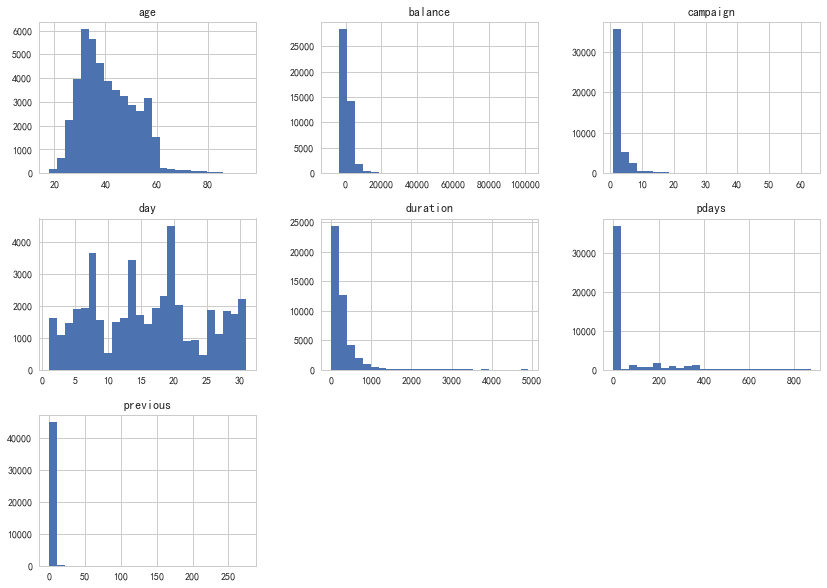

In [69]:
bank.hist(bins=25, figsize=(14,10))
plt.show()

## 2.2.类别型特征对结果的影响
接下来我们查看正负样本点的不同之处。我们首先通过调用 `barplot()` 函数查看受教育程度 `education` 对结果（是否会定期存款）的影响。观察下图我们可以看出，受过高等教育（tertiary）和中等教育（secondary）的人群比只接受过初等教育的人更容易认购定期存款。

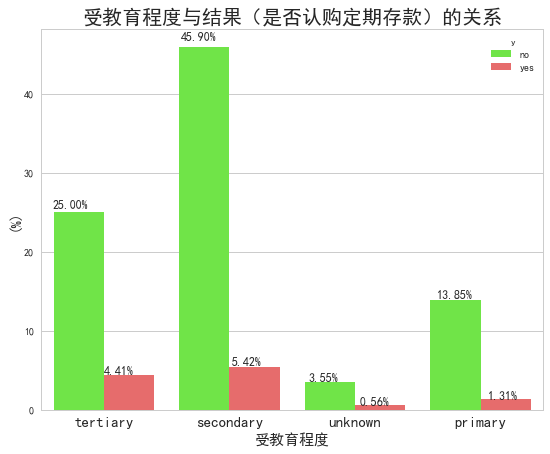

In [70]:
f, ax = plt.subplots(1,1, figsize=(9,7))

palette = ["#64FE2E", "#FA5858"]
sns.barplot(x="education", y="balance", hue="y", data=bank, palette=palette, estimator=lambda x: len(x) / len(bank) * 100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()),(p.get_x() * 1.02, p.get_height() * 1.02),fontsize=12)
    
ax.set_xticklabels(bank["education"].unique(), rotation=0, rotation_mode="anchor",fontsize=15)
ax.set_title("受教育程度与结果（是否认购定期存款）的关系",fontsize=20)
ax.set_xlabel("受教育程度",fontsize=15)
ax.set_ylabel("(%)",fontsize=15)
plt.show()

观察年龄随职业的分布，可以看出职业为 retired、self-employed两类左右两侧的分布有较明显的差别。在退休人群(retired)中，年龄越大的人越容易购买产品；个体经营(self-employed)群体中，年轻化的人更容易购买产品；观察年龄岁婚姻状况的分布，可以看出结婚的人(married)、离婚的人(divorced)相对于单身的人在是否会认购定期存款方面分布有明显的差异，前两类群体在高龄中越容易购买产品。

## 2.3.特征间的相关性
接下来我们通过关系矩阵查看各特征之间的关系，如下图所示。

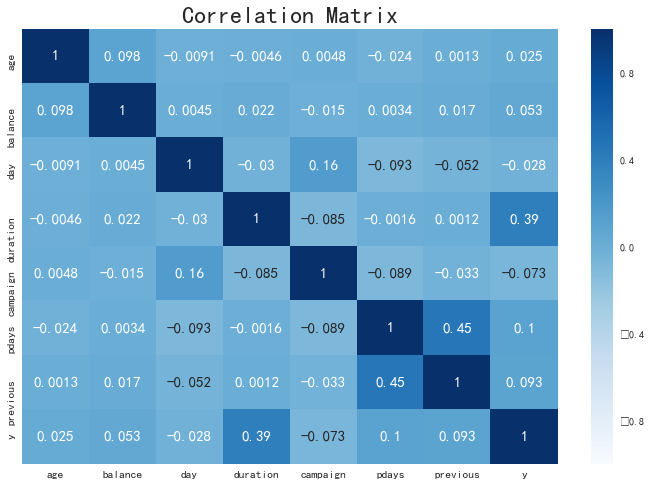

In [71]:
fig, ax = plt.subplots(figsize=(12, 8))
bank['y'] = LabelEncoder().fit_transform(bank['y'])
numeric_bank = bank.select_dtypes(exclude="object")
corr_numeric = numeric_bank.corr()#关系矩阵，以矩阵形式存储

sns.heatmap(corr_numeric, annot=True, vmax=1, vmin=-1, cmap="Blues",annot_kws={"size":15})#热力图，即关系矩阵
ax.set_title("Correlation Matrix", fontsize=24)
ax.tick_params(axis='y',labelsize=11.5)
ax.tick_params(axis='x',labelsize=11.5)
plt.show()

观察上图我们可以看出通话时长（ `duration` ）与结果（ `y` ）相关性很高。这也可以很通俗地理解，如果通话时长 = 0，则y =0；如果通话时长越长，则客户越有可能接受银行的营销活动而认购定期存款（如下图所示）。

但是在实际中，这样做会有一个很大的问题，因为在执行通话之前你并不知道 `duration` 会是多久。但是，在通话结束后，显然你就会知道客户的意愿是认购还是拒绝。因此，应在模型训练前将这一特征删除。在下图，我们把 `duration` 按**低于或高于其平均值**分成了 **below_average** 和 **over_average** 两类，探究这两种情况下人们购买意愿的差异。根据我们的假设，属于 **below_average** 的人群中大多数人不会认购定期存款，属于 **over_average** 的人群中大多数人会选择认购定期存款。下方的代码生成的图像验证了我们的猜想。

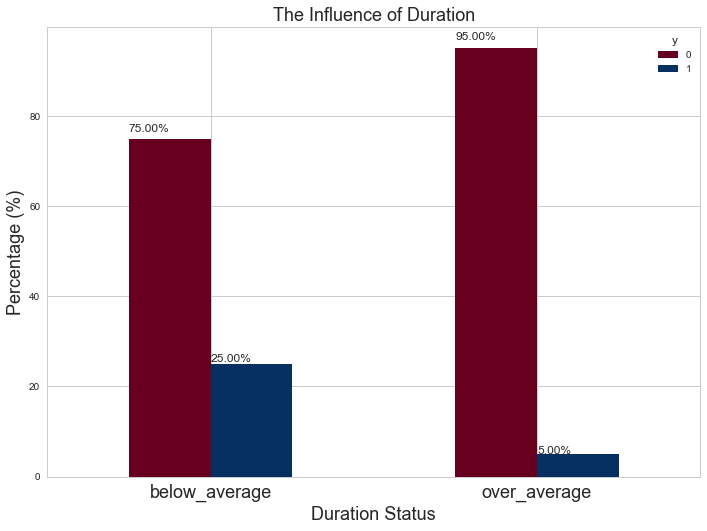

In [72]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')
avg_duration = bank['duration'].mean()
#建立一个新特征以区分大于duration平均值的duration和小于均值的duration
bank["duration_status"] = np.nan
lst = [bank]
for col in lst:
    col.loc[col["duration"] < avg_duration, "duration_status"] = "below_average"
    col.loc[col["duration"] > avg_duration, "duration_status"] = "above_average"

#pd.crosstab另外一种分析双变量的方式,通过它可以得到两个变量之间的交叉信息，并作图。
pct_term = pd.crosstab(bank['duration_status'], bank['y']).apply(lambda r: round(r/r.sum(), 2) * 100, axis=1)
ax = pct_term.plot(kind='bar', stacked=False, cmap='RdBu')
ax.set_xticklabels(['below_average','over_average'], rotation=0, rotation_mode="anchor",fontsize=18)
plt.title("The Influence of Duration", fontsize=18)
plt.xlabel("Duration Status", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() , p.get_height() * 1.02))
plt.show()
bank.drop(['duration_status'], axis=1, inplace=True)

确实， **over_average** 的情况下就已经有95%的人选择认购定期存款了，这印证了我们的猜想。但是在本例中，我们不对`duration`做删除处理。大家可以尝试删除此特征执行同样的步骤，根据[总结](#5.总结)中最后一段提出的分别应用这两个模型进行预测的策略，应用到实际情况中。

# 3.数据预处理与特征工程
## 3.1.缺失值处理

在本文的开始我们提到过，虽然对所有数值型特征不存在缺失值，但是类别型特征中有以 `'unknown'` 形式存在的值，它们的统计结果如下，代码已在文章开头给出。

|列名|unknown值个数|
|:-:|:-:|
|job|288|
|marital|0|
|education|1857|
|default|0|
|housing|0|
|loan|0|
|contact|13020|
|month|0|
|poutcom|36959|
|y|0|


缺失值处理通常有如下的方法：

1.对于 `'unknown'` 值数量较少的特征，包括`job`和`education`，删除这些特征是缺失值(`'unknown'`)的行；<p>2.如果预计该特征对于学习模型效果影响不大，而且在此例中缺失值都是类别型数据，可以对(`'unknown'`)值赋众数；<p>
3.可以使用数据完整的行作为训练集，以此来预测缺失值，特征`concact`，`poutcome`的缺失值可以采取此法；<p>
4.我们也可以不处理它，使其保留 `'unknown'` 的形式作为该特征的一种可能取值。

这里我们采取策略4，不进行处理。原因可以参考下一行代码，例如上一次营销活动的结果(`poutcome`)这一特征，大部分都是 `'unknown'` 值，其原因可以归结于这些客户没有经历上一次营销活动，是第一次参加本活动。当然，我们也可以结合策略1、3进行处理。 

In [73]:
bank['poutcome'].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

## 3.2.类型转换
我们知道原数据表中有数值型和类别型两种数据类型，但是机器学习模型只能读取数值型数据，因此我们需要进行类型的转换。通常我们可以先通过 `LabelEncoder` 再通过 `OneHotEncoder` 将str型数据转换成独热编码。但是这样每次只能操作一个类别型数据，函数写起来会比较麻烦。

在最新的开发者版本sklearn中提供了 `CategoricalEncoder`，它的好处是可以直接转换多列类别型数据。虽然当前版本没有提供，但是下面的代码块中供
了 `CategoricalEncoder` 的方法，只需要运行即可。

In [74]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown
    #fit方法与其他Encoder的使用方法一样
    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """
        #编码有三种方式，按顺序分别为稀疏形式的独热编码，独热编码和序列编码。
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")
        #处理特征
        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape
        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]
        #CategoricalEncoder的具体思路如下：
        #先用LabelEncoder()转换成序列数据，再用OneHotEncoder()增添新的列转换成独热编码
        #在fit阶段，只提取每一列的类别信息，为transform阶段做准备。
        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        #处理特征
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)
        #转换类别型变量到独热编码的步骤
        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])
            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])
        #对于序列编码，直接处理后返回
        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)
        #以下是处理类别型数据的步骤
        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)
        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]
        #默认是以稀疏矩阵的形式输出，节约内存
        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        #将稀疏矩阵转换成普通矩阵
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [75]:
bank[['job','marital']].head(5)

,job,marital
0,management,married
1,technician,single
2,entrepreneur,married
3,blue-collar,married
4,unknown,single


In [76]:
a = CategoricalEncoder().fit_transform(bank[['job','marital']])
a.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [77]:
a.shape

(45211, 15)

In [78]:
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,0
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,0
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,0
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,0
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,0


In [79]:
#DataFrameSelector类的作用是从DataFrame中选取特定的列，以便后续pipeline的便捷性。
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

Python的 `sklearn.pipeline.Pipeline()` 函数可以把多个“处理数据的节点”按顺序打包在一起，数据在前一个节点处理之后的结果，转到下一个节点处理。当训练样本数据送进 `Pipeline` 进行处理时， 它会逐个调用节点的 `fit()` 和 `transform()` 方法，然后用最后一个节点的 `fit()` 方法来拟合数据。

对于数值型特征，我们对它用 `StandardScaler()` 进行标准化，对于类别型特征，我们用 `CategoricalEncoder(encoding='onehot-dense')` 进行独热编码。

In [80]:
# 制作管道

# #对数值型特征处理
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["age", "balance", "day", "campaign", "pdays", "previous","duration"])),
    ("std_scaler", StandardScaler()),
])
#对类别型特征处理
categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["job", "education", "marital", "default", "housing", "loan", "contact", "month","poutcome"])),
    ("cat_encoder", CategoricalEncoder(encoding='onehot-dense'))
])

#统一管道
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

# 4.模型训练
## 4.1.数据集划分

In [82]:
# 划分X和y，以及训练集与测试集
X=bank.drop(['y'], axis=1)
y=bank['y']
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown


In [83]:
X = preprocess_pipeline.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=44)

In [85]:
X

array([[ 1.60696496,  0.25641925, -1.29847633, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.28852927, -0.43789469, -1.29847633, ...,  0.        ,
         0.        ,  1.        ],
       [-0.74738448, -0.44676247, -1.29847633, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.92540065,  1.42959305,  0.14341818, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.51279098, -0.22802402,  0.14341818, ...,  0.        ,
         0.        ,  1.        ],
       [-0.37068857,  0.52836436,  0.14341818, ...,  1.        ,
         0.        ,  0.        ]])

In [20]:
preprocess_bank = pd.DataFrame(X)
preprocess_bank.head(5)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.606965,0.256419,-1.298476,-0.569351,-0.411453,-0.25194,0.011016,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.288529,-0.437895,-1.298476,-0.569351,-0.411453,-0.25194,-0.416127,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.747384,-0.446762,-1.298476,-0.569351,-0.411453,-0.25194,-0.707361,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.571051,0.047205,-1.298476,-0.569351,-0.411453,-0.25194,-0.645231,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.747384,-0.447091,-1.298476,-0.569351,-0.411453,-0.25194,-0.233620,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
bank.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


## 4.2.模型构建

In [22]:
t_diff=[]
# 逻辑回归
log_reg = LogisticRegression()
t_start = time.clock()#通过time记录
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
log_reg_mean = log_scores.mean()

# 支持向量机
svc_clf = SVC()
t_start = time.clock()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
svc_mean = svc_scores.mean()

# k邻近
knn_clf = KNeighborsClassifier()
t_start = time.clock()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
knn_mean = knn_scores.mean()

# 决策树
tree_clf = tree.DecisionTreeClassifier()
t_start = time.clock()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
tree_mean = tree_scores.mean()

# 梯度提升树
grad_clf = GradientBoostingClassifier()
t_start = time.clock()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
grad_mean = grad_scores.mean()

# 随机森林
rand_clf = RandomForestClassifier()
t_start = time.clock()
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
rand_mean = rand_scores.mean()

# 神经网络
neural_clf = MLPClassifier(alpha=0.01)
t_start = time.clock()
neural_scores = cross_val_score(neural_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
neural_mean = neural_scores.mean()

# 朴素贝叶斯
nav_clf = GaussianNB()
t_start = time.clock()
nav_scores = cross_val_score(nav_clf, X_train, y_train, cv=3, scoring='roc_auc')
t_end = time.clock()
t_diff.append((t_end - t_start))
nav_mean = neural_scores.mean()

d = {'Classifiers': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC', 'Neural Classifier', 'Naives Bayes'], 
    'Crossval Mean Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean, neural_mean, nav_mean],
    'time':t_diff}

result_df = pd.DataFrame(d)
result_df = result_df.sort_values(by=['Crossval Mean Scores'], ascending=False)
result_df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureW

,Classifiers,Crossval Mean Scores,time
4,Grad B CLF,0.925765,26.047404
6,Neural Classifier,0.919359,82.371689
7,Naives Bayes,0.919359,0.207923
1,SVC,0.907706,71.862459
0,Logistic Reg.,0.905835,0.742473
5,Rand FC,0.886541,1.250071
2,KNN,0.829659,68.490700
3,Dec Tree,0.701087,1.155549


## 4.3.模型评价
由上表可以看出，在这8种分类器里面，梯度提升树（Gradient Boosting）、神经网络（Neural Classifier）、朴素贝叶斯（Naive Bayes）表现位于前三名。在后续的步骤中，我们可以对它们进行调参以获得更好的结果，相信大家一定会调参，所以调参不是本文关注的重点，本文的重点在于各个模型的比较。

虽然决策树位列最后一名，但是集成树（梯度提升树与随机森林）表现可以远远好于单棵决策树。这是由于集成模型的泛化性能非常好，不太需要调参就可以取得很好的效果。

而在耗时方面，k邻近算法由于要同时计算所有点与某点的距离，因此耗时最多，而且效果也一般（倒数第二）。集成模型虽然需要训练上百个弱分类器，但是由于可以并行计算的原因，随机森林与单棵决策树的速度相差无几；而根据梯度提升树的原理，它只可以分步计算，所以速度稍慢。但是最慢的还是神经网络，最快的模型是决策树。

In [23]:
#通过该函数获得一个分类器的AUC值与ROC曲线的参数
def get_auc(clf):
    clf=clf.fit(X_train, y_train)
    prob=clf.predict_proba(X_test)
    prob=prob[:, 1]
    return roc_auc_score(y_test, prob),roc_curve(y_test, prob)

通过测试集数据画出ROC曲线并标注AUC值。

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


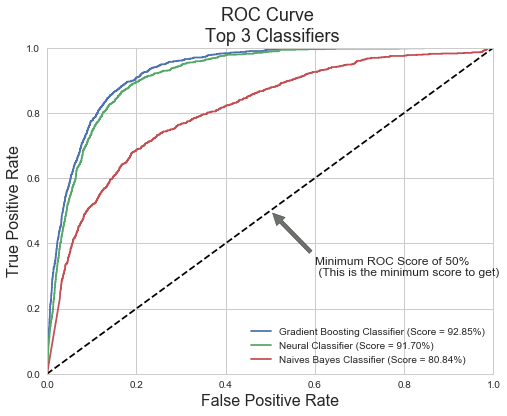

In [24]:
grad_roc_scores,grad_roc_curve = get_auc(grad_clf)
neural_roc_scores,neural_roc_curve = get_auc(neural_clf)
naives_roc_scores,naives_roc_curve = get_auc(nav_clf)

grd_fpr, grd_tpr, grd_thresold = grad_roc_curve
neu_fpr, neu_tpr, neu_threshold = neural_roc_curve
nav_fpr, nav_tpr, nav_threshold = naives_roc_curve

def graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr):
    plt.figure(figsize=(8,6))
    plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
    plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier (Score = {:.2%})'.format(grad_roc_scores))
    plt.plot(neu_fpr, neu_tpr, label='Neural Classifier (Score = {:.2%})'.format(neural_roc_scores))
    plt.plot(nav_fpr, nav_tpr, label='Naives Bayes Classifier (Score = {:.2%})'.format(naives_roc_scores))
    plt.plot([0, 1], [0, 1], 'k--')#指定x,y轴的坐标在0，1之间
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3), arrowprops=dict(facecolor='#6E726D', shrink=0.05),)
    plt.legend()#显示图例
    
graph_roc_curve_multiple(grd_fpr, grd_tpr, neu_fpr, neu_tpr, nav_fpr, nav_tpr)
plt.show()

由上图可见，在测试集中朴素贝叶斯模型只得到了80.84%的AUC值了，说明它存在过拟合现象，需要进一步调参。而梯度提升树（Gradient Boosting）与神经网络（Neural Classifier）的得分与训练集的结果保持一致，说明模型拟合地很好，因此它们也是我们可以采纳的模型。

# 5.总结

首先，在营销活动次数的选择上，对同一个客户打电话的次数不应超过三次，这样不仅可以节约时间，把精力投入到新客户中。如果给同一个客户打电话多次，一定会引起客户的反感，从而降低客户的购买产品的欲望。

其次，在客户年龄段的选择上，银行应集中于20岁左右和60岁左右的人群，他们分别有超过60%的可能性购买营销产品。

再其次，对于不同的职业来说，学生与退休的人也是最容易购买营销产品的人，这与年龄段的现象保持了一致。对于退休的人而言，他们有很多的存款却不敢随便花钱，而定期存款大多期限短收益高，因而成为他们所热衷购买的产品。而对于学生党来说，他们会珍惜自己有限的存款，而同时他们花钱的机会比较少，所以他们会选择定期存款。

而对于住房贷款和存款余额来说，正如本文中的结果所能看到的一样，有贷款的人需要每月按时还款，因而不太可能还会去购买定期存款（定期存款的利息肯定不及贷款利息）。同时，存款多的人自然倾向于去购买定期存款以让自己获得更多利息。

最后一点，专注于那些通话时间长的客户，正如在关系矩阵中所看到的一样，通话时间越长客户越有可能购买营销产品，而且可能性非常之高。

综上所述，对于银行而言，想要推广它的营销产品，一个简要的策略是：首先先通过客户的基本信息，使用训练好的机器学习模型（不含`duration`）进行预测，然后对这些客户进行电话营销。根据电话营销的结果，再用含有`duration`的模型再一次进行预测，找出那些可能性大的客户，如果他们没有在第一次营销后购买理财产品的话，那么再对这些人进行第二次电话营销。之后，视情况进行第三次营销，或者把精力放在发展新客户上面。通过这样的策略，银行下一次营销活动的可能结果会比上一次更好。